In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.special
import os
from astropy.io import fits
from scipy.interpolate import CubicSpline
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib.lines import Line2D

### This code assumes that all the simulation l1 and the prediction l1 is already computed or that you have access to them!

#### the derivatives are obtained for n realisations for a given Cosmology and then the mean and the error of mean is computed from them

In [2]:
def top_hat_window(k,R):
        return 2. * scipy.special.j1(k*R) / (k*R)

def get_W2D(window_radius, map):
        N = map.shape[0]
        box_length = 512 # Mpc/h  # define the length of the box in Mpc/h and the number of grid points
        dx = box_length / N # calculate the grid spacing in Mpc/h
        kx, ky = np.fft.fftshift(np.fft.fftfreq(N,dx)), np.fft.fftshift(np.fft.fftfreq(N,dx))
        kx, ky = np.meshgrid(kx, ky, indexing='ij')
        k2 = (kx**2 + ky**2)
        k = 2*np.pi*np.sqrt(k2) #/ box_length
        ind = int(N/2)
        k[ind,ind] = 0.0000001
        return top_hat_window(k,window_radius)
    
def get_smoothed_app_pdf(map,W2D_1,W2D_2,bin_edge):
    field_ft = np.fft.fftshift(np.fft.fftn(map))
    convergence_smoothed_ft1 = field_ft*W2D_1
    convergence_smoothed_ft2 = field_ft*W2D_2
    convergence_smoothed1 = np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(convergence_smoothed_ft1)).real)
    convergence_smoothed2 = np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(convergence_smoothed_ft2)).real) 
    convergence_app = convergence_smoothed2 - convergence_smoothed1
    convergence_app = convergence_app
    counts_, bin_edges_ = np.histogram(convergence_app, density=True, bins=bin_edge)
    return bin_edges_, counts_, convergence_app  

def get_l1_1st(map, bin_edges):
    snr = map
    thresholds_snr = bin_edges # np.linspace(np.min(snr), np.max(snr), nbins + 1)
    bins_snr = 0.5 * (thresholds_snr[:-1] + thresholds_snr[1:])
    digitized = np.digitize(snr, thresholds_snr)
    bin_l1_norm = [np.sum(np.abs(snr[digitized == i]))
                    for i in range(1, len(thresholds_snr))]
    return thresholds_snr, bins_snr, bin_l1_norm

def get_no_of_pixels(patch_size, smoothing_scale_arcmin, dimension):
    x = patch_size
    y = smoothing_scale_arcmin
    n = dimension
    side_length_degrees = np.sqrt(x)  # Length of one side in degrees
    resolution_deg_per_pixel = side_length_degrees / n  # Angular resolution in degrees per pixel
    smoothing_scale_degrees = y / 60  # Smoothing scale in degrees
    pixels_for_smoothing = smoothing_scale_degrees / resolution_deg_per_pixel  # Number of pixels
    return pixels_for_smoothing

In [3]:
theta = 22.5
window_radius = round(get_no_of_pixels(12.25, theta,512))
print(window_radius)

55


In [4]:
# Define the base folder for all models
parent_folder = "/feynman/work/dap/lcs/vt272285/data/sim_data/MassiveNus/"


# Model parameters for each model
models = {
    "model_one": {"mnv": 0.00000, "om": 0.30000, "As": 2.1000},
    "model_two": {"mnv": 0.09041, "om": 0.28447, "As": 2.1757},
    "model_three": {"mnv": 0.10000, "om": 0.30000, "As": 2.1000},
    "model_four": {"mnv": 0.11874, "om": 0.31434, "As": 2.0079},
}

# Dynamically generate paths for each model
def generate_paths(models):
    redshifts = [0.5, 1.0, 1.5, 2.0, 2.5]
    for model_name, params in models.items():
        base_name = f"convergence_gal_mnv{params['mnv']:.5f}_om{params['om']:.5f}_As{params['As']:.4f}"
        paths = {z: os.path.join(parent_folder, f"{base_name}/Maps{int(z*10)}") for z in redshifts}
        models[model_name]["paths"] = paths

# Populate model dictionaries with paths
generate_paths(models)

NameError: name 'kappa' is not defined

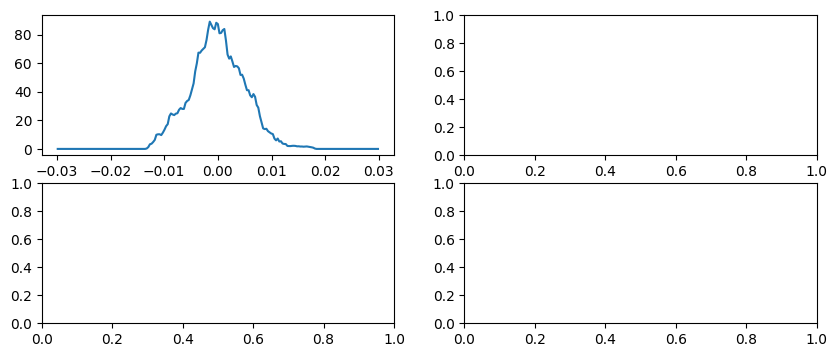

In [5]:
def get_file_name(model_name, redshift, file_number, models):
    try:
        model = models[model_name]
        folder_path = model["paths"][redshift]
        filename = f"WLconv_z{redshift:.2f}_{file_number:04d}r.fits"
        return os.path.join(folder_path, filename)
    except KeyError as e:
        raise ValueError(f"Missing data: {e}")
    
try:
    redshift = 2  
    model1_name = "model_one"
    file_numbers = 2 #from 1 til 10000 
    bin_edges = np.linspace(-0.03, 0.03, 200)
    bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])
    derivatives_pdf = np.zeros((file_numbers, len(bin_centers)))
    derivatives_l1 = np.zeros((file_numbers, len(bin_centers)))
    fig, axs = plt.subplots(2,2,figsize=(10,4))
    for file_number in range(1,file_numbers):
        full_file_path1 = get_file_name(model1_name, redshift, file_number, models)
        with fits.open(full_file_path1) as hdu:
            data1 = hdu[0].data
            
        if file_number==1:
            W2D_1 = get_W2D(window_radius, data1)
            W2D_2 = get_W2D(2*window_radius, data1)
            
        _, counts1, convergence_app1 = get_smoothed_app_pdf(data1, W2D_1, W2D_2, bin_edges)
        _, _, bin_l1_norm1 = get_l1_1st(convergence_app1, bin_edges)
        model2_name = "model_two"
        full_file_path2 = get_file_name(model2_name, redshift, file_number, models)
        with fits.open(full_file_path2) as hdu:
            data2 = hdu[0].data
        _, counts2, convergence_app2 = get_smoothed_app_pdf(data2, W2D_1, W2D_2, bin_edges)
        _, _, bin_l1_norm2 = get_l1_1st(convergence_app2, bin_edges)
        
        derivatives_pdf[file_number,:] = (counts2 - counts1)*0.5/(0.31434 - 0.28447)
        derivatives_l1[file_number,:] = (np.array(bin_l1_norm2) - np.array(bin_l1_norm1))*0.5/(0.31434 - 0.28447)
        axs[0,0].plot(bin_centers, counts1)
        axs[0,0].plot(kappa, pdf_pred_4(kappa))
        
        axs[0,1].plot(bin_centers, bin_l1_norm1)
        axs[0,1].plot(bin_centers,l1_pred_4(kappa)/(512*512*(kappa[1]-kappa[0])))
        
        axs[1,0].plot(bin_centers, derivatives_pdf[file_number,:])
        axs[1,1].plot(bin_centers, derivatives_l1[file_number,:])
        
    plt.show()  
except ValueError as err:
    print(err)

fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].errorbar(bin_centers, np.mean(derivatives_pdf,axis=0),yerr = np.std(derivatives_pdf,axis=0),marker='o')
axs[1].errorbar(bin_centers, np.mean(derivatives_l1,axis=0),yerr = np.std(derivatives_l1,axis=0),marker='o')
plt.show()

# deriv_pdf = np.array([bin_centers, np.mean(derivatives_pdf,axis=0), np.std(derivatives_pdf,axis=0)])
# deriv_l1 = np.array([bin_centers, np.mean(derivatives_l1,axis=0), np.std(derivatives_l1,axis=0)])
# file_path_pdf = "/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/paper/data/derivatives_pdf_om"
# file_path_l1 = "/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/paper/data/derivatives_l1_om" 
# np.save(file_path_pdf, deriv_pdf.T)
# np.save(file_path_l1, deriv_l1.T)

In [ ]:
derivative_pdf_mnu = np.load("/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/paper/data/derivatives_pdf_mnu.npy").T
derivative_pdf_om = np.load("/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/paper/data/derivatives_pdf_om.npy").T
derivative_pdf_As = np.load("/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/paper/data/derivatives_pdf_As.npy").T

derivative_l1_mnu = np.load("/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/paper/data/derivatives_l1_mnu.npy").T
derivative_l1_om = np.load("/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/paper/data/derivatives_l1_om.npy").T
derivative_l1_As = np.load("/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/paper/data/derivatives_l1_As.npy").T


In [ ]:
def get_params(model_name):
    if model_name in models:
        model_parameters = models[model_name]
        mnv = model_parameters["mnv"]
        om = model_parameters["om"]
        As = model_parameters["As"]
    else:
        print(f"Model {model_name} not found in the dictionary. Please check your inputs.")
    return mnv, om, As

def get_loaded_pdf(mnv, om, As,window_radius, redshift):
    main_folder = "/feynman/work/dap/lcs/vt272285/codes/massivenus_pdf/"
    filename = main_folder +  f"prediction_pdf_redshift{redshift}_mnv{mnv:.5f}_As{As:.4f}_Om{om:.5f}_radius{window_radius}.npy"
    print(filename)
    # Load the data from the .npy file
    data = np.load(filename, allow_pickle=True).item()

    # Access the loaded data
    kappa = data["kappa"]
    pdf_prediction = data["prediction"]
    pdf_simulation = data["simulation"]
    std_simulation = data['std_sim']
    return kappa, pdf_prediction, pdf_simulation, std_simulation

def get_loaded_l1(mnv, om, As,window_radius, redshift):
    main_folder = "/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/paper/data/"
    filename_pred = main_folder +  f"prediction_l1_redshift{redshift}_mnv{mnv:.5f}_As{As:.4f}_Om{om:.5f}_radius{window_radius}.npy"
    print(filename_pred)
    # Load the data from the .npy file
    data = np.load(filename_pred, allow_pickle=True).item()
    # Access the loaded data
    kappa = data["kappa"]
    l1_prediction = data["prediction"]
    l1_simulation = data["simulation"]
    std_sim = data["std_sim"]
    return kappa, l1_prediction, l1_simulation, std_sim

window_radius = 22.55859375
redshift = 2

def get_splines_pdf(model):
    mnv, om, As = get_params(model)
    kappa, pred, sim, err = get_loaded_pdf(mnv, om, As, window_radius, redshift)
    # plt.plot(kappa,pred)
    pred_spline = CubicSpline(kappa,pred)
    sim_spline = CubicSpline(kappa,sim)
    # err_spline = CubicSpline(kappa,err)
    
    return mnv, om, As, pred_spline, sim_spline #, err_spline

def get_splines_l1(model):
    mnv, om, As = get_params(model)
    kappa, pred, sim, err = get_loaded_l1(mnv, om, As, window_radius, redshift)
    pred_spline = CubicSpline(kappa,pred)
    # err_spline = CubicSpline(kappa,err)
    sim_spline = CubicSpline(kappa,sim)
    return pred_spline, sim_spline #, err_spline

mnv_1, om_1, As_1, pdf_pred_1, pdf_sim_1 = get_splines_pdf("model_one")
mnv_2, om_2, As_2, pdf_pred_2, pdf_sim_2 = get_splines_pdf("model_two") 
mnv_3, om_3, As_3, pdf_pred_3, pdf_sim_3 = get_splines_pdf("model_three") 
mnv_4, om_4, As_4, pdf_pred_4, pdf_sim_4 = get_splines_pdf("model_four") 
l1_pred_1, l1_sim_1 = get_splines_l1("model_one")
l1_pred_2, l1_sim_2 = get_splines_l1("model_two") 
l1_pred_3, l1_sim_3 = get_splines_l1("model_three") 
l1_pred_4, l1_sim_4 = get_splines_l1("model_four")  

/feynman/work/dap/lcs/vt272285/codes/massivenus_pdf/prediction_pdf_redshift2_mnv0.00000_As2.1000_Om0.30000_radius22.55859375.npy
/feynman/work/dap/lcs/vt272285/codes/massivenus_pdf/prediction_pdf_redshift2_mnv0.09041_As2.1757_Om0.28447_radius22.55859375.npy
/feynman/work/dap/lcs/vt272285/codes/massivenus_pdf/prediction_pdf_redshift2_mnv0.10000_As2.1000_Om0.30000_radius22.55859375.npy
/feynman/work/dap/lcs/vt272285/codes/massivenus_pdf/prediction_pdf_redshift2_mnv0.11874_As2.0079_Om0.31434_radius22.55859375.npy
/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/paper/data/prediction_l1_redshift2_mnv0.00000_As2.1000_Om0.30000_radius22.55859375.npy
/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/paper/data/prediction_l1_redshift2_mnv0.09041_As2.1757_Om0.28447_radius22.55859375.npy
/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/paper/data/prediction_l1_redshift2_mnv0.10000_As2.1000_Om0.30000_radius22.55859375.npy
/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/pap

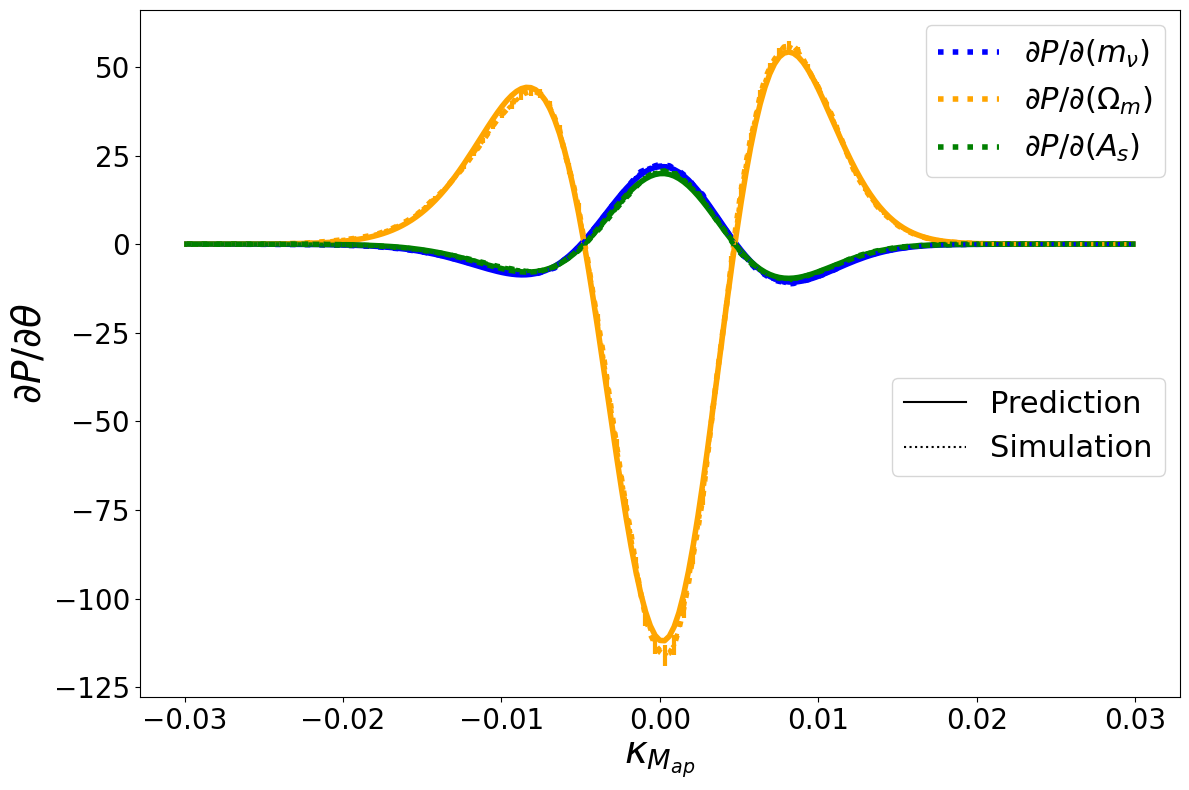

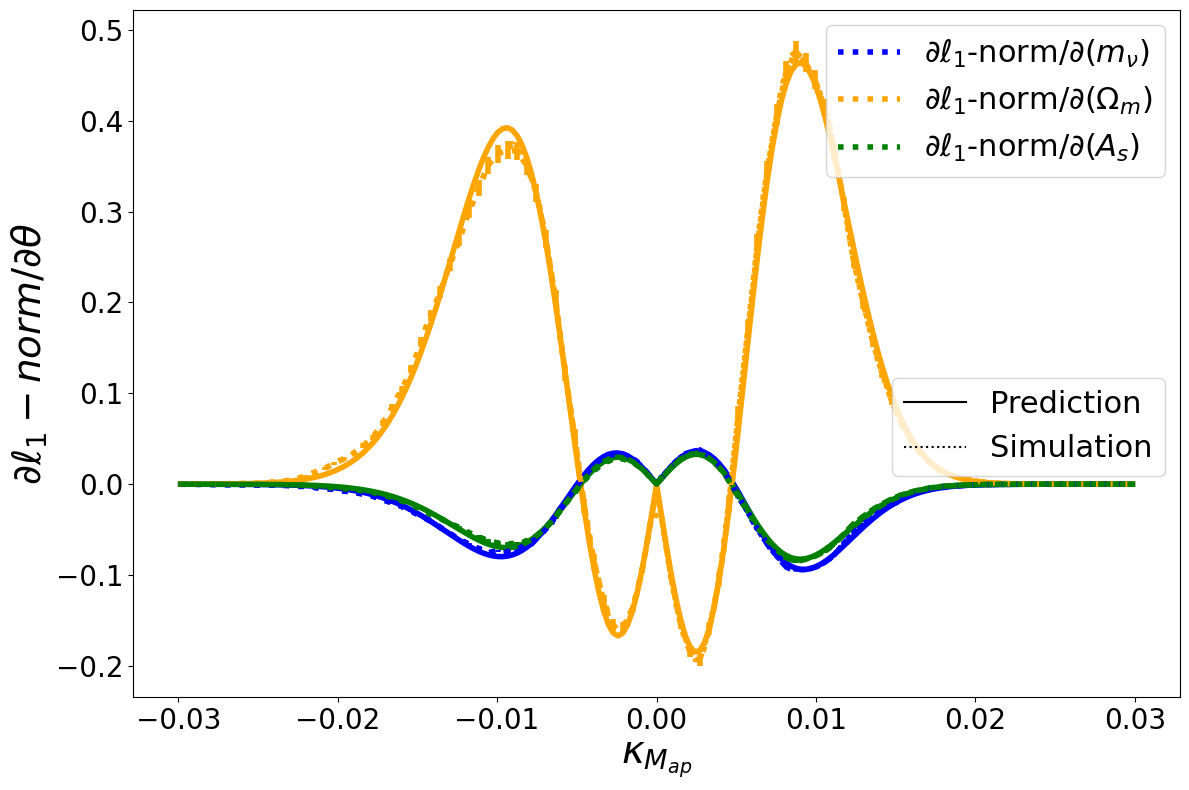

In [ ]:
legend_elements_1 = [
    Line2D([0], [0], color='blue', linestyle='-', label=r'Prediction at $\theta=22.55$'),
    Line2D([0], [0], color='blue', linestyle='--', label='Simulation'),
]


kappa = derivative_l1_As[0]

fig = plt.figure(figsize=(12,8))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

ax0 = fig.add_subplot(1,1,1) 


legend_size = 22
label_size = 28
line_width = 4 
ax0.plot(kappa,(pdf_pred_3(kappa)-pdf_pred_1(kappa))/(mnv_3-mnv_1),c='blue', lw = line_width)
dp1, = ax0.plot(kappa,derivative_pdf_mnu[1],ls=":", c='blue', label=r'$\partial P / \partial(m_\nu)$',lw = line_width)
ax0.errorbar(kappa[::2],derivative_pdf_mnu[1][::2],yerr = derivative_pdf_mnu[2][::2]/np.sqrt(10000),ls=":", c='blue', label=r'$\partial P / \partial(m_\nu)$',lw = line_width-1)

ax0.plot(kappa,(pdf_pred_4(kappa)-pdf_pred_2(kappa))*0.5/(om_4-om_2),c='orange', lw = line_width)
dp2, = ax0.plot(kappa,-derivative_pdf_om[1], ls=":",c='orange', label=r'$\partial P / \partial(\Omega_m)$', lw = line_width)
ax0.errorbar(kappa[::2],-derivative_pdf_om[1][::2],yerr=derivative_pdf_om[2][::2]/np.sqrt(10000), ls=":",c='orange', label=r'$\partial P / \partial(\Omega_m)$', lw = line_width-1)

ax0.plot(kappa,(pdf_pred_2(kappa)-pdf_pred_4(kappa))*0.5/(As_2-As_4),c='green', lw = line_width)
dp3, = ax0.plot(kappa,-derivative_pdf_As[1],ls=":",c='green', label=r'$\partial P / \partial(A_s)$', lw = line_width)
ax0.errorbar(kappa[::2],-derivative_pdf_As[1][::2], yerr=derivative_pdf_As[2][::2]/np.sqrt(10000),ls=":",c='green', label=r'$\partial P / \partial(A_s)$', lw = line_width-1)

legend_pdf = [dp1,dp2,dp3]
ax0.set_ylabel(r"$\partial P/\partial \theta$",fontsize=label_size)
ax0.set_xlabel(r'$\kappa_{M_{ap}}$',fontsize=label_size)

legend_zs_box = ax0.legend(handles=legend_pdf, loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=legend_size)
custom_legend = [Line2D([0], [0], linestyle="-", color='black', label='Prediction'),
                 Line2D([0], [0], linestyle=":", color='black', label='Simulation')]
ax0.legend(handles=custom_legend, loc='lower right', bbox_to_anchor=(1, 0.3), fontsize=legend_size)
plt.tight_layout()
ax0.add_artist(legend_zs_box)
plt.savefig(os.getcwd()+"/derivative_pdf.png", dpi=600)
# plt.legend(handles=legend_elements_1, loc='upper right')
# ax0.grid(True)

fig = plt.figure(figsize=(12,8))
matplotlib.rc('xtick', labelsize=20) 
ax1 = fig.add_subplot(1,1,1)  

index = np.where(np.abs(kappa) - 0. == np.min(np.abs(kappa)-0.))
l1_pred3 = l1_pred_3(kappa)
l1_pred1 = l1_pred_1(kappa)
l1_sim3 = l1_sim_3(kappa)
l1_sim1 = l1_sim_1(kappa)


l1_dpred = l1_pred3-l1_pred1
l1_dpred[index[0]] = 0.0
l1_dsim = l1_sim3-l1_sim1
l1_dsim[index[0]] = 0.0

factor = 512*512*(bin_centers[1]-bin_centers[0])
ax1.plot(kappa,(l1_dpred)/(mnv_3-mnv_1),c='blue', lw = line_width)
dl1, = ax1.plot(kappa,derivative_l1_mnu[1]/factor,ls=":",c='blue',  label=r'$\partial \ell_1$-norm$/ \partial(m_\nu)$', lw = line_width)
ax1.errorbar(kappa[::2],derivative_l1_mnu[1][::2]/factor, yerr=derivative_l1_mnu[2][::2]/factor/np.sqrt(10000),ls=":",c='blue',  label=r'$\partial \ell_1$-norm$/ \partial(m_\nu)$', lw = line_width)

ax1.plot(kappa,(l1_pred_4(kappa)-l1_pred_2(kappa))*0.5/(om_4-om_2),c='orange', lw = line_width)
dl2, = ax1.plot(kappa,-derivative_l1_om[1]/factor,ls=":",c='orange',  label=r'$\partial \ell_1$-norm$/ \partial(\Omega_m)$', lw = line_width)
ax1.errorbar(kappa[::2],-derivative_l1_om[1][::2]/factor, yerr=derivative_l1_om[2][::2]/factor/np.sqrt(10000),ls=":",c='orange',  label=r'$\partial \ell_1$-norm$/ \partial(\Omega_m)$', lw = line_width)

ax1.plot(kappa,(l1_pred_2(kappa)-l1_pred_4(kappa))*0.5/(As_2-As_4),c='green', lw = line_width)
dl3, = ax1.plot(kappa,-derivative_l1_As[1]/factor,ls=":",c='green',  label=r'$\partial \ell_1$-norm$/ \partial(A_s)$', lw = line_width)
ax1.errorbar(kappa[::2],-derivative_l1_As[1][::2]/factor, yerr=derivative_l1_As[2][::2]/factor/np.sqrt(10000),ls=":",c='green',  label=r'$\partial \ell_1$-norm$/ \partial(A_s)$', lw = line_width)


legend_l1 = [dl1,dl2,dl3]
ax1.set_ylabel(r"$\partial \ell_1-norm/\partial \theta$",fontsize=label_size)
ax1.set_xlabel(r'$\kappa_{M_{ap}}$',fontsize=label_size)

legend_zs_box = ax1.legend(handles=legend_l1, loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=legend_size)
custom_legend = [Line2D([0], [0], linestyle="-", color='black', label='Prediction'),
                 Line2D([0], [0], linestyle=":", color='black', label='Simulation')]
ax1.legend(handles=custom_legend, loc='lower right', bbox_to_anchor=(1, 0.3), fontsize=legend_size)
plt.tight_layout()
ax1.add_artist(legend_zs_box)
plt.savefig(os.getcwd()+"/derivative_l1_norm.png", dpi=600)
# ax1.grid(True)